## US Election 2020 Tweets Analysis

The ["US Election 2020 Tweets" dataset](https://www.kaggle.com/datasets/manchunhui/us-election-2020-tweets/data) provides an extensive collection of tweets from around the world that include hashtags related to the 2020 U.S. presidential candidates, Biden and Trump.

### Objectives
For this analysis, we will focus exclusively on single tweets from each unique Twitter user based in the United States, and in English, to perform text analysis with three main goals:

- **Tweets distribution Analysis**: Clear the dataset and prepare it for a general analysis. Describe how tweets are distributed between the two U.S. candidates in all US and across federal states;
- **Global Sentiment Analysis**: Clear the dataset and prepare it for a Sentiment Text Analysis. Assess the sentiment of the global population of Twitter users towards Biden and Trump evaluating which sentiment preveals on each of them;
- **Federal States Sentiment Analysis**: Assess the sentiment of each Federal state Twitter users towards Biden and Trump and use it as a proxy for the election outcome (**Subsection A**). Evaluate the power of the proxy using the outcome of 2020 elections (**Subsection B**). 


---------------

# Federal States Sentiment Analysis

This code is organized into two main sections:

- **Section A: Creation of a Sentiment Proxy**
In this section, tweets from each federal state are categorized as "positive," "neutral," or "negative" toward each candidate. By summing the positive tweets for a candidate and the negative ones for the opponent, we derive an overall preference for each candidate within each state.

- **Section B: Evaluating Proxy Effectiveness in the 2020 U.S. Elections**
This section provides a descriptive comparison between the predictive power of the tweet-based proxy and the actual results of the 2020 U.S. election. A final graph illustrates the proxy’s accuracy in predicting election outcomes.

The research findings and potential directions for future work are presented at the conclusion.

In [2]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.io as pio
from pathlib import Path
import os
# Libraries for Sentiment Analysis 
import re 
import nltk 
from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob 
from wordcloud import WordCloud 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, words
from nltk.probability import FreqDist

### Load Data

In [3]:
# Define the base path
base_path = Path("C:/Users/Davide/Desktop/Alma Mater/SECOND YEAR/PYTHON/Python_project")
# Change the working directory
os.chdir(base_path)

# Define the full path to the CSV file for Trump and Biden
merged_data = base_path / "data/data.csv" #this dataset is already restricted to the US

# Print the current working directory
print("Current Working Directory:", Path.cwd())

Current Working Directory: C:\Users\Davide\Desktop\Alma Mater\SECOND YEAR\PYTHON\Python_project


In [55]:
try:
    data = pd.read_csv(merged_data, encoding="utf-8", engine='python', on_bad_lines='skip')
    print("First 5 rows of the DataFrame:")
    print(data.head())
except Exception as e:
    print("Error loading the file:", e)

First 5 rows of the DataFrame:
   index           created_at      tweet_id  \
0      0  2020-10-15 00:00:01  1.316529e+18   
1      2  2020-10-15 00:00:02  1.316529e+18   
2      4  2020-10-15 00:00:08  1.316529e+18   
3      5  2020-10-15 00:00:17  1.316529e+18   
4      7  2020-10-15 00:00:18  1.316529e+18   

                                               tweet  likes  retweet_count  \
0  #Elecciones2020 | En #Florida: #JoeBiden dice ...    0.0            0.0   
1  #Trump: As a student I used to hear for years,...    2.0            1.0   
2  You get a tie! And you get a tie! #Trump ‘s ra...    4.0            3.0   
3  @CLady62 Her 15 minutes were over long time ag...    2.0            0.0   
4  @DeeviousDenise @realDonaldTrump @nypost There...    0.0            0.0   

                source       user_id  \
0            TweetDeck  3.606665e+08   
1      Twitter Web App  8.436472e+06   
2   Twitter for iPhone  4.741380e+07   
3  Twitter for Android  1.138416e+09   
4   Twitter for i

# *A* - Federal States Sentiment Analysis: The Creation of a Proxy

In [56]:
#retain only the columns "tweet", "state_code" and "candidate"
data = data [['tweet', 'state_code', 'candidate']]
print(data)

                                                    tweet state_code candidate
0       #Elecciones2020 | En #Florida: #JoeBiden dice ...         FL     trump
1       #Trump: As a student I used to hear for years,...         OR     trump
2       You get a tie! And you get a tie! #Trump ‘s ra...         DC     trump
3       @CLady62 Her 15 minutes were over long time ag...         CA     trump
4       @DeeviousDenise @realDonaldTrump @nypost There...         OH     trump
...                                                   ...        ...       ...
394390  #election #2020Elections #trump #biden https:/...         NY     biden
394391  @GOP @GOPLeader @senatemajldr @LindseyGrahamSC...         MA     biden
394392  @FLOTUS I’m excited to have a FLOTUS whose vag...         DC     biden
394393  The man needs some help...#usa #biden\nWhen wi...         ID     biden
394394  LIONZ DEN PRESENTS TO YOU \n\n“THE WHITE OBAMA...         MN     biden

[394395 rows x 3 columns]


### Data Cleaning

In [57]:
#verify whether there are missing values and drop rows that have missing values in either one of the three columns
print('NaN for each variable:\n', data.isna().sum(axis=0))  #sum by line the missing values foe each variable
print('\nTotal NaN ', data.isna().sum(axis=0).sum()) #total number of missing values

NaN for each variable:
 tweet             0
state_code    61931
candidate         0
dtype: int64

Total NaN  61931


In [58]:
#the only missing values are in state code. We drop all rows with a missing value for the State code
data = data.dropna(subset=['state_code'], how='any') #if there is a missing value in state_code, then the line is dropped
data.shape  #create a new dataframe. the resulting dataframe had 332464 rows and 3 columns

(332464, 3)

### Sentiment Analysis By U.S. Federal States

 **Note**: 
 
 states differ widely in terms of the number of tweets. This makes our proxy for electoral outcomes less reliable in states with a low number of tweets. However, since within each state the number of tweets for each candidate is similar, our sentiment analysis by state is not biased by a disproportionately higher amount of tweets for one candidate

Dropping US territories that are not relevant for presidency electoral outcomes

In [ ]:
#check that we have all US states. 
unique_US_states_count = data['state_code'].nunique()
unique_US_states = data['state_code'].unique()
print(unique_US_states)
# There are 54 states. they should be 50. Hence there are 3 codes that do not indicate States, but rather US territories. these are:
#PR - Puerto Rico (U.S. territory)
#GU - Guam (U.S. territory)
#MP - Northern Mariana Islands (U.S. territory)

# However, The District of Columbia even if it's not a proper federal state, has the 5th highes network of tweeters as our desciptive analysis reveald. 
# for this reason can be a good idea leave DC in the analysis
#DC - District of Columbia (federal district) 

# drop the 3 US territories in order to perform the analysis by US state
codes_to_drop = ['PR', 'GU', 'MP'] #we retain DC as it is the 5th territory with the highest number of tweets and is relevant for the presidential election's outcome
data = data[~data['state_code'].isin(codes_to_drop)] #exclude rows where state code is any of the four listed in codes to drop

# Check if any of the unwanted codes are still in the 'state_code' column
unwanted_codes_present = data['state_code'].isin(codes_to_drop).any()
if unwanted_codes_present:
    print("There are still unwanted codes in the data.")
else:
    print("All unwanted codes have been successfully removed from the data.")




['FL' 'OR' 'DC' 'CA' 'OH' 'PA' 'IL' 'MI' 'NJ' 'MA' 'NH' 'TX' 'SD' 'GA'
 'MO' 'NY' 'CO' 'SC' 'VA' 'AL' 'AZ' 'NC' 'TN' 'NE' 'LA' 'NV' 'MN' 'IN'
 'WA' 'HI' 'WV' 'VT' 'ID' 'PR' 'IA' 'KY' 'ND' 'AR' 'WI' 'UT' 'MT' 'KS'
 'WY' 'ME' 'CT' 'MD' 'NM' 'OK' 'AK' 'DE' 'RI' 'MS' 'GU' 'MP']
All unwanted codes have been successfully removed from the data.


### Functions

functions for cleaning the dataset

In [ ]:
import unicodedata #needed to turn bold and italics into lowercase text
def clean(text): 
	# Remove URLs 
	text = re.sub(r'https?://\S+|www\.\S+', '', str(text)) 

	# Convert text to lowercase (after turning bold and italics into normal text)
	text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8').lower()

	# Replace anything other than alphabets a-z with a space 
	text = re.sub('[^a-z]', ' ', text) 

	# Split the text into single words 
	text = text.split() 

	# Initialize WordNetLemmatizer 
	lm = WordNetLemmatizer() 

	# Lemmatize words and remove stopwords 
	text = [lm.lemmatize(word) for word in text if word not in set( 
		stopwords.words('english'))] 

	# Join the words back into a sentence 
	text = ' '.join(word for word in text) 

	return text 

functions for performing sentiment analysis

The TextBlob library provides an interface for processing textual data. TextBlob(text) creates a TextBlob object from the input text.
1) ".sentiment.polarity" computes the polarity score, which is a float ranging from -1 to 1. A polarity score close to 1 indicates positive sentiment; a polarity score close to -1 indicates negative sentiment; a score of 0 indicates neutral sentiment. TextBlob calculates this score by summing up the individual sentiment scores of words or phrases, adjusted by their context. It then averages these values to get a single polarity score for the whole text
2) ".sentiment.subjectivity" calculates a subjectivity score, which is a float ranging from 0 to 1. A subjectivity score close to 1 means the text is subjective or opinion-based; a score close to 0 indicates the text is objective or fact-based. TextBlob’s subjectivity score for the text is calculated by identifying words that express opinions or feelings. Each subjective word increases the subjectivity score, while neutral or factual words decrease it. TextBlob averages these results to determine an overall subjectivity score.
3) "getAnalysis" takes as input the polarity score and labels it as positive, neutral or negative.



In [ ]:
def getpolarity(text): 
    return TextBlob(text).sentiment.polarity 

def getsubjectivity(text): 
    return TextBlob(text).sentiment.subjectivity 

def getAnalysis(score): 
    if score < 0: 
        return 'negative'
    elif score == 0: 
        return 'neutral'
    else: 
        return 'positive'

### Grouping by States

group tweets for both candidates by US state

In [75]:
# Create a dictionary to hold dataframes for each state
state_dataframes = {}

# Loop through each state code and create a separate DataFrame for each statecode
for state in unique_US_states:
    state_dataframes[state] = data[data['state_code'] == state][['tweet', 'candidate']]

# Example: Accessing the DataFrame for California (CA)
california_df = state_dataframes['CA']  
print("California DataFrame:")
print(california_df)
# Example: Accessing the DataFrame for Wyoming (WY)
Wyoming_df = state_dataframes['WY']  
print("Wyoming DataFrame:")
print(Wyoming_df)

California DataFrame:
                                                    tweet candidate
3       @CLady62 Her 15 minutes were over long time ag...     trump
7       #Trump #PresidentTrump #Trump2020LandslideVict...     trump
15      #BlacksForTrump \n#BlackVoicesForTrump \n#Bide...     trump
19      #TheWeek: "#Trump in Penn: "I saved suburbia. ...     trump
21      #Trump is tearing up #Biden at the #TrumpRally...     trump
...                                                   ...       ...
394346  On what date can we officially start blaming a...     biden
394370  Oigan como que ganó #Biden la #precidencia y d...     biden
394375  LIONZ DEN PRESENTS TO YOU \n\n“THE WHITE OBAMA...     biden
394381  #Election2020 President #Trump addresses Joe #...     biden
394386  #Biden 🗽🇺🇸👍🏽 | Images 📷 @ Santa Maria, CA.  | ...     biden

[56964 rows x 2 columns]
Wyoming DataFrame:
                                                    tweet candidate
486     Confessions of the secret suburban Trump 

### Results of the Sentiment Analysis

this step creates a loop which, for each state, considers separately the subset of tweets on Trump and the subset of tweets on Biden. After cleaning the tweets and applying the functions for sentiment analysis, the loop computes the total number of positive and negative tweets for each subset. The results for each state are appended in the list 'results', which is then converted into a dataframe for further analyses

In [78]:
# Initialize a list where we store the results of the sentiment analysis. this will be converted into a dataframe for futher analyses
results = []

# Iterate over each state's DataFrame in the dictionary
for state, df in state_dataframes.items(): #the key is a state code, and the value is the dataframe for that state. Each iteration processes a single state's dataframe
    # First consider only tweets referring to Trump
    trump_tweets = df[df['candidate'] == 'trump'].copy() # a subset of df is created, containing only rows where candidate == trump
    trump_tweets['cleaned_tweet'] = trump_tweets['tweet'].apply(clean) #The clean function is applied to each tweet in trump_tweets, storing the cleaned version in a new column cleaned_tweet
    trump_tweets['polarity'] = trump_tweets['cleaned_tweet'].apply(getpolarity)
    trump_tweets['subjectivity'] = trump_tweets['cleaned_tweet'].apply(getsubjectivity)
    trump_tweets['sentiment'] = trump_tweets['polarity'].apply(getAnalysis)

    # Count positive and negative sentiments for Trump
    trump_positive_count = (trump_tweets['sentiment'] == 'positive').sum()
    trump_negative_count = (trump_tweets['sentiment'] == 'negative').sum()

    # Then consider only tweets referring to Biden
    biden_tweets = df[df['candidate'] == 'biden'].copy() #a subset of df is created, containing only rows where candidate == biden
    biden_tweets['cleaned_tweet'] = biden_tweets['tweet'].apply(clean)
    biden_tweets['polarity'] = biden_tweets['cleaned_tweet'].apply(getpolarity)
    trump_tweets['subjectivity'] = trump_tweets['cleaned_tweet'].apply(getsubjectivity)
    biden_tweets['sentiment'] = biden_tweets['polarity'].apply(getAnalysis)

    # Count positive and negative sentiments for Biden
    biden_positive_count = (biden_tweets['sentiment'] == 'positive').sum()
    biden_negative_count = (biden_tweets['sentiment'] == 'negative').sum()

    # Store results in a list
    results.append({
        'State': state,
        'Trump Positive': trump_positive_count,
        'Trump Negative': trump_negative_count,
        'Biden Positive': biden_positive_count,
        'Biden Negative': biden_negative_count
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results) 

In [114]:
print(results_df.tail())

   State  Trump Positive  Trump Negative  Biden Positive  Biden Negative  \
47    OK             299             204             294             136   
48    AK             136              56             149             102   
49    DE              59              39             131              52   
50    RI              83              54              83              35   
51    MS              90              61              98              68   

    Trump Preference TW  Biden Preference TW  Total Polarity TW  \
47                  435                  498                933   
48                  238                  205                443   
49                  111                  170                281   
50                  118                  137                255   
51                  158                  159                317   

    % Trump Preferences TW  % Biden Preferences TW   Winner TW  Trump wins TW  \
47               46.623794               53.376206  Biden w

### Proxy Computation

Given the assumptions of our analysis reported below *, we compute our tweets' proxy for electoral outcomes. 

**RECALL ASSUMPTIONS** *

- *Voting system*: absolute majority rule (50.01% wins) implies that a candidate is assumed to win in a state if he has an absolute majority in percentage preferences according to the tweets' sentiment
- *The neutral don't vote*: everyone with a neutral sentiment towards a candidate doesn't take part in the votation
- People are coherent with tweets statement (i.e., a negative tweet on Trump is equivalent to a positive tweet for Biden). This assumption makes it possible to eliminate all duplicate users (i.e., if a user appears twice, leaving both a tweet on biden and a tweet on trump, only one of the two is retained)

Under these assumptions our proxy for the preference expressed toward a given candidate is given by **the sum of the positive tweets toward that candidate and the negative tweets toward the other candidate**

In [105]:
# Now calculate preferences using the stored counts
results_df['Trump Preference TW'] = results_df['Trump Positive'] + results_df['Biden Negative']
results_df['Biden Preference TW'] = results_df['Biden Positive'] + results_df['Trump Negative']
results_df['Total Polarity TW'] = results_df['Biden Positive'] + results_df['Trump Negative'] + results_df['Trump Positive'] + results_df['Biden Negative'] #the total number of positive and negative tweets for both candidates
results_df['% Trump Preferences TW'] = (results_df['Trump Preference TW'] / results_df['Total Polarity TW']) * 100
results_df['% Biden Preferences TW'] = (results_df['Biden Preference TW'] / results_df['Total Polarity TW']) * 100
results_df['Winner TW'] = np.where(
    results_df['% Trump Preferences TW'] > results_df['% Biden Preferences TW'],
    'Trump wins',
    'Biden wins'
) #np.where is a function from the NumPy library that evaluates a condition and returns one of two specified values depending on whether the condition is True or False

# Creating a dummy variable for Trump's victory
results_df['Trump wins TW'] = (results_df['Winner TW'] == 'Trump wins').astype(int)

# Creating a dummy variable for Biden's victory
results_df['Biden wins TW'] = (results_df['Winner TW'] == 'Biden wins').astype(int)
# Display the final results
print(results_df.head())

  State  Trump Positive  Trump Negative  Biden Positive  Biden Negative  \
0    FL            5533            3292            4546            2187   
1    OR            1128             872             871             417   
2    DC            3165            1988            2521             976   
3    CA            9976            7257            9825            4210   
4    OH            1381             924            1408             626   

   Trump Preference TW  Biden Preference TW  Total Polarity TW  \
0                 7720                 7838              15558   
1                 1545                 1743               3288   
2                 4141                 4509               8650   
3                14186                17082              31268   
4                 2007                 2332               4339   

   % Trump Preferences TW  % Biden Preferences TW   Winner TW  Trump wins TW  \
0               49.620774               50.379226  Biden wins           

In [93]:
results_df = results_df.dropna(how="any") #drop any row with a missing value in the results dataframe, if any
print(results_df.tail()) #print the tail

   State  Trump Positive  Trump Negative  Biden Positive  Biden Negative  \
47    OK             299             204             294             136   
48    AK             136              56             149             102   
49    DE              59              39             131              52   
50    RI              83              54              83              35   
51    MS              90              61              98              68   

    Trump Preference TW  Biden Preference TW  Total Polarity TW  \
47                  435                  498                933   
48                  238                  205                443   
49                  111                  170                281   
50                  118                  137                255   
51                  158                  159                317   

    % Trump Preferences TW  % Biden Preferences TW   Winner TW  Trump wins TW  \
47               46.623794               53.376206  Biden w

In [107]:
# Counting the number of occurrences of "Trump wins" and "Biden wins" in column "Winner TW"
winner_counts = results_df['Winner TW'].value_counts()

# Printing our prediction results
print("Prediction Results:")
print(winner_counts)

Prediction Results:
Winner TW
Biden wins    44
Trump wins     7
Name: count, dtype: int64


In [109]:
# Save as a CSV file
results_df.to_csv("tweet_preferences.csv", index=False)


# *B* - Federal States Sentiment Analysis: Proxy Power in 2020 U.S. elections

In [1]:
# Import Libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.io as pio
from pathlib import Path
import os

In [3]:
# Define the base path
base_path = Path("C:/Users/Davide/Desktop/Alma Mater/SECOND YEAR/PYTHON/Python_project")
# Change the working directory
os.chdir(base_path)

# Define the full path to the CSV file for Trump and Biden
merged_data = base_path / "data/voting.csv" #this dataset is already restricted to the US

# Print the current working directory
print("Current Working Directory:", Path.cwd())

Current Working Directory: C:\Users\Davide\Desktop\Alma Mater\SECOND YEAR\PYTHON\Python_project


In [4]:
political_outcomes = pd.read_csv(merged_data)
political_outcomes = political_outcomes.rename(columns={'state_abr': 'State'}) #State will be used for merging this dataset with the twitter one
political_outcomes = political_outcomes.rename(columns={'state': 'federal state'}) #full name of the state
print(political_outcomes.head())

  federal state State  trump_pct  biden_pct  trump_vote  biden_vote  \
0        Alaska    AK       53.1       43.0      189543      153502   
1        Hawaii    HI       34.3       63.7      196864      366130   
2    Washington    WA       39.0       58.4     1584651     2369612   
3        Oregon    OR       40.7       56.9      958448     1340383   
4    California    CA       34.3       63.5     5982194    11082293   

   trump_win  biden_win  
0          1          0  
1          0          1  
2          0          1  
3          0          1  
4          0          1  


Merge the data on elections outcomes with the data reflecting sentiments toward candidatates and check if the preferences by the voters corresponds to preferences expressed by twitter users

In [6]:
# Define the full path to the CSV file for Trump and Biden
tweet_preferences = base_path / "data/tweet_preferences.csv" 

tweet_preferences = pd.read_csv(tweet_preferences)
print(tweet_preferences.head())

  State  Trump Positive  Trump Negative  Biden Positive  Biden Negative  \
0    FL            5526            3313            4542            2203   
1    OR            1128             878             869             423   
2    DC            3166            1999            2520             981   
3    CA            9969            7303            9820            4240   
4    OH            1381             927            1406             631   

   Trump Preference  Biden Preference  Total Polarity  % Trump Preferences  \
0              7729              7855           15584            49.595739   
1              1551              1747            3298            47.028502   
2              4147              4519            8666            47.853681   
3             14209             17123           31332            45.349802   
4              2012              2333            4345            46.306099   

   % Biden Preferences  ... Trump wins  Biden wins  Trump Preference TW  \
0    

Merge the two datasets by the common column "State", which uniquely identifies each state. The rows in tweet_preferences and political_outcomes will be aligned based on matching values in this column. This is a left join, meaning all rows from tweet_preferences will be included in the merged DataFrame, comparison_df. If there are matching rows in political_outcomes for a given state, those rows are combined. If there are no matching rows in political_outcomes for a state present in tweet_preferences, the columns from political_outcomes will contain NaN for that row in comparison_df

In [7]:
comparison_df = tweet_preferences.merge(political_outcomes, on="State", how="left") #merge the two datasets by state. Call the resulting dataframe comparison_df
print(comparison_df.head())

  State  Trump Positive  Trump Negative  Biden Positive  Biden Negative  \
0    FL            5526            3313            4542            2203   
1    OR            1128             878             869             423   
2    DC            3166            1999            2520             981   
3    CA            9969            7303            9820            4240   
4    OH            1381             927            1406             631   

   Trump Preference  Biden Preference  Total Polarity  % Trump Preferences  \
0              7729              7855           15584            49.595739   
1              1551              1747            3298            47.028502   
2              4147              4519            8666            47.853681   
3             14209             17123           31332            45.349802   
4              2012              2333            4345            46.306099   

   % Biden Preferences  ...   Winner TW  Trump wins TW  Biden wins TW  \
0      

In [8]:
# Obtain column names
column_names = comparison_df.columns

# Print column names
print("Columns of the merged dataset comparison_df are:", list(column_names))

Columns of the merged dataset comparison_df are: ['State', 'Trump Positive', 'Trump Negative', 'Biden Positive', 'Biden Negative', 'Trump Preference', 'Biden Preference', 'Total Polarity', '% Trump Preferences', '% Biden Preferences', 'Winner', 'Trump wins', 'Biden wins', 'Trump Preference TW', 'Biden Preference TW', 'Total Polarity TW', '% Trump Preferences TW', '% Biden Preferences TW', 'Winner TW', 'Trump wins TW', 'Biden wins TW', 'federal state', 'trump_pct', 'biden_pct', 'trump_vote', 'biden_vote', 'trump_win', 'biden_win']


Creating a column to check whether our proxy predicts well actual electoral outcomes. We use two separate conditions to check if our prediction matches the actual electoral outcome. We use the logical operator 'OR': If either of the two conditions is true, the value in 'Tweet Correct' will be true

In [9]:
# Creating a column to check whether our proxy predicts well actual electoral outcomes
comparison_df['Tweet Correct'] = (
    (comparison_df['Trump wins TW'] == 1) & (comparison_df['trump_win'] == 1) | 
    (comparison_df['Biden wins TW'] == 1) & (comparison_df['biden_win'] == 1)
)

# Counting correct predictions
correct_count = comparison_df['Tweet Correct'].value_counts()
print("correct predictions:", correct_count)

correct predictions: Tweet Correct
True     29
False    22
Name: count, dtype: int64


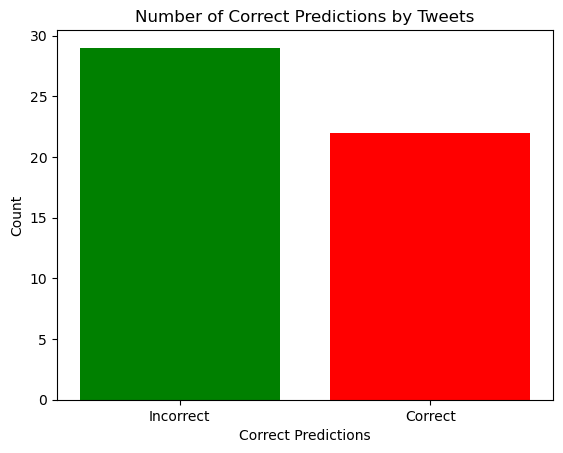

In [10]:
# plotting incorrect and correct predictions
plt.bar(correct_count.index.astype(str), correct_count.values, color=['green', 'red'])
plt.title('Number of Correct Predictions by Tweets')
plt.xlabel('Correct Predictions')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Incorrect', 'Correct'])
plt.show()

## Final Comment

Overall, Twitter data indicates a general preference toward Biden. In fact, our proxy based on the sentiment analysis of tweets predicts that Biden wins in 44 of the federal states.  However, our tweets' sentiment proxy for electoral outcomes turned out to not be a particularly good predictor of the 2020 presidential elections' outcomes. This may be due to the strict assumptions upon which our proxy rests, such as the assumption that neutral tweets do not matter and that a positive tweet toward a candidate is equivalent to a negative tweet toward the other candidate by the same user. Moreover, states differ widely in terms of the total number of tweets, making our proxy less reliable in states with a low number. However, within states, there is not a huge difference in terms of the number of tweets on each candidate. Hence, our sentiment analysis is based on a relatively balanced sample.

It’s worth noting that, although the number of tweets using Trump-related hashtags is significantly higher, many of these tweets tend to carry a critical tone. Therefore, the general preference toward Biden expressed on Twitter may simply be due to the disliking expressed toward Trump's controversial character, and may not translate into a pro-Biden voting behaviour.
It is also important to highlight that there may be a discrepancy between active Twitter users and the voting population. For instance, the former may be relatively younger and leaning toward the democratic party with respect to the latter. 
 
Ultimatelly , these considerations lead us to conclude that, although there is great potential for improvement in harnessing social media data to gauge political preferences and even form predictions, *our proposed proxy is not reliable for predicting electoral outcomes*. However, it may provide a rough way to gauge *public sentiment*, which appears to be generally critical of Trump.

## Future contributions

To deepen this analysis, generating a predictive model could help capture social media users’ preference dynamics more accurately. For instance, it would be useful to **generate a distribution that assigns to neutral tweets a certain kind of voting behaviour** with a given probability and **considere the weights that each american federal state has in the president elections**. A more **nuanced sentiment analysis**, capturing sentiment more in-depth with respect to the labels "positive", "neutral" and "negative", would also be able to capture information that is ignored by our proxy and is potentially relevant for predictions. A final suggested refainment could be to consider dynamics where, over time, the **same users may make statements on Twitter that are inconsistent with their past ones**, and assign greater weight to tweets made closer to the election date.

Integrating these approaches for the Tweets Proxy into a forecasting deep learning model could significantly enhance the analysis !!!